In [1]:
#basic LIB
import numpy as np
import pandas as pd
import os
import warnings
import sys
from numpy import asarray
from numpy import zeros
#dataset
from keras.datasets import imdb
#Visulization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML,display
import random
#Preprosessing
import nltk
import gensim
from gensim.models import Word2Vec,Phrases
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk import pos_tag
from nltk.corpus import wordnet 

#Model Building
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Conv1D, MaxPool1D,GlobalMaxPooling1D, Dense, Dropout , LSTM,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import legacy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [42]:
!pip install --upgrade nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.9 MB/s eta 0:00:0000:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [6]:
nltk.download('wordnet')  # download the corpus
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ 

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/co

## Load IMDB data and conver them to dataframe 50K record

In [3]:
from keras.datasets import imdb

In [4]:
num_words = 10000 # Change this to adjust the vocabulary size
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Decode the reviews back to English words
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


1641221/1641221 [==============================] - 0s 0us/step


In [5]:

# Decode all reviews in the training data
reviews = []
for review in train_data:
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in review])
    reviews.append(decoded_review)

# Decode all reviews in the test data
for review in test_data:
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in review])
    reviews.append(decoded_review)

In [6]:
# combine all labels
Labels = []
for label in train_labels:
    Labels.append(label)
test_reviews = []
for label in test_labels:
    Labels.append(label)

In [7]:
df = pd.DataFrame({'review': reviews, 'sentiment': Labels})

In [8]:
df['sentiment']=df['sentiment'].map({ 1 : 'positive',  0 : 'negative'})

# *Data Analysis*

In [9]:
df.info()  
#our data consist od 50K records with 2 columns 1 feature and 1 Label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
df.groupby(['sentiment']).describe()
#25K Positive and 25 K negative  thus our data is balanced and with 24698 , 24884 unique words for each 
#and  3 , 5  Frequency 
#let's combine them and see what's total uniqe value

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  ? when i got this movie free from my job along...   
positive   25000  24881  ? loved today's show it was a variety and not ...   

                
          freq  
sentiment       
negative     3  
positive     5

In [11]:
df['review'].nunique()
# 49582 unique word

49579

In [12]:
#let's check if there is duplicate values
duplicates = df[df.duplicated()]
print(f'Number of duplicate rows: {len(duplicates)}')
#yes there is duplicated values

Number of duplicate rows: 421


In [13]:
#let's check for null 
df.isnull().sum()
#there is no null values at any column

review       0
sentiment    0
dtype: int64

<AxesSubplot: xlabel='sentiment', ylabel='count'>

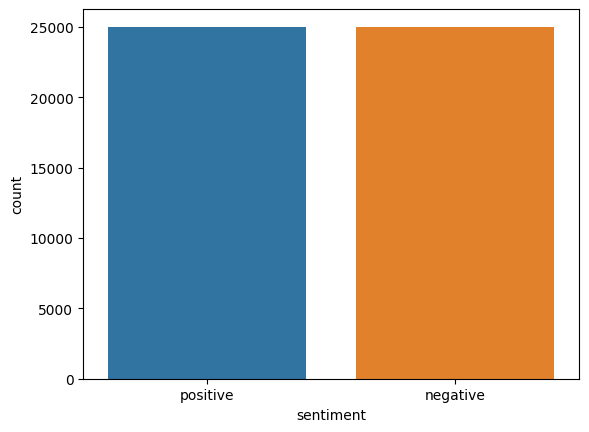

In [14]:
sns.countplot(x=df['sentiment']) #ploting distribution for easier understanding

In [15]:
#let's see our dataframe
df.head(3)

,review,sentiment
0,? this film was just brilliant casting locatio...,positive
1,? big hair big boobs bad music and a giant saf...,negative
2,? this has to be one of the worst films of the...,negative


In [16]:
#let's see how data is looklike
random_index=random.randint(0,df.shape[0]-3)
for row in df[['review','sentiment']][random_index:random_index+3].itertuples():
    _,text,label=row
    class_name="Positive"
    if label==0:
        class_name="Negative"
    display(HTML(f"<h5><b style='color:red'>Text: </b>{text}</h5>"))
    display(HTML(f"<h5><b style='color:red'>Target: </b>{class_name}<br><hr></h5>"))
#data contain so much garbage needs to be cleaned

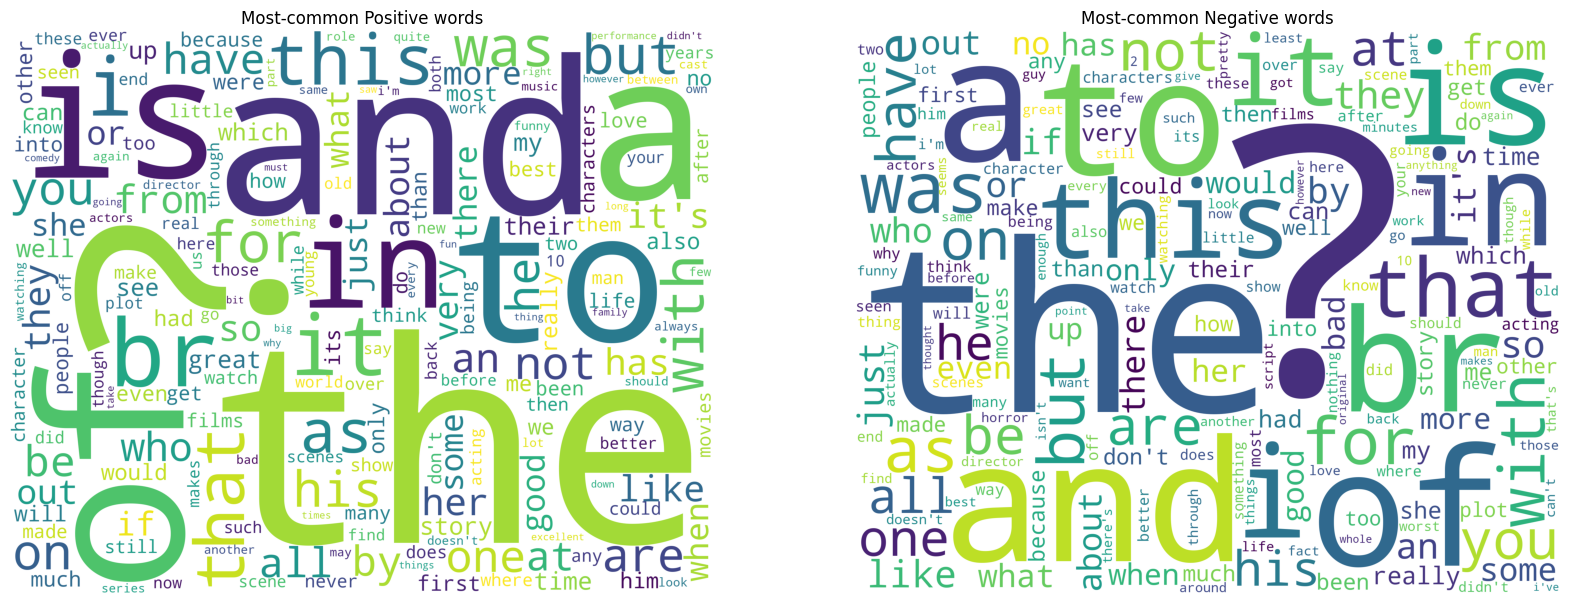

In [17]:
positivedata = df[df['sentiment']== 'positive']
positivedata =positivedata['review']
negdata = df[df['sentiment']== 'negative']
negdata= negdata['review']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if (word not in ['movie', 'film'])])
    if not cleaned_word:
        cleaned_word = 'no_data'  # Set a default value if there are no words
    word_counts = Counter(cleaned_word.split())
    if not word_counts:
        word_counts = {'no_data': 1}  # Set a default value if there are no words
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate_from_frequencies(word_counts)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Most-common Positive words')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Most-common Negative words')
plt.show()

* First let's remove duplicates

In [18]:
df.drop_duplicates(inplace=True)
if df.duplicated().sum()==0:   
    print('Duplicates Removed')
else:
    print('there is still duplicates')

Duplicates Removed


* Let's look again at distribution

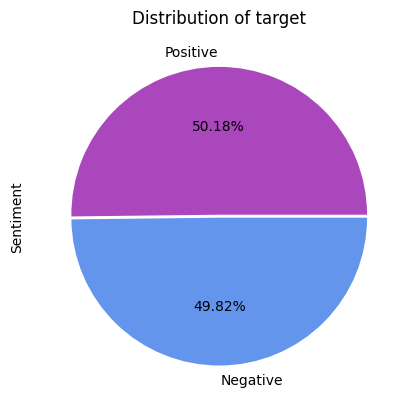

In [19]:
colors=['#AB47BC','#6495ED']
plt.pie(df['sentiment'].value_counts(),labels=['Positive','Negative'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.title('Distribution of target')
plt.ylabel('Sentiment');
#data still balanced

In [20]:
df['text_word_count']=df['review'].apply(lambda x:len(x.split()))

numerical_feature_cols=['text_word_count']


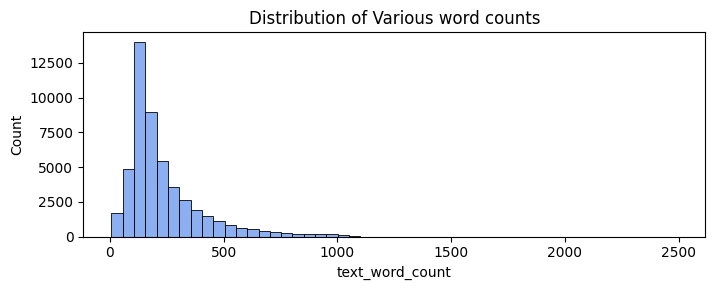

In [21]:

plt.figure(figsize=(20,3))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,bins=50,color='#6495ED')
    plt.title(f"Distribution of Various word counts")
plt.tight_layout()
plt.show()

**The distribution of text word count is Right skewed and contains a lot of outliers.**

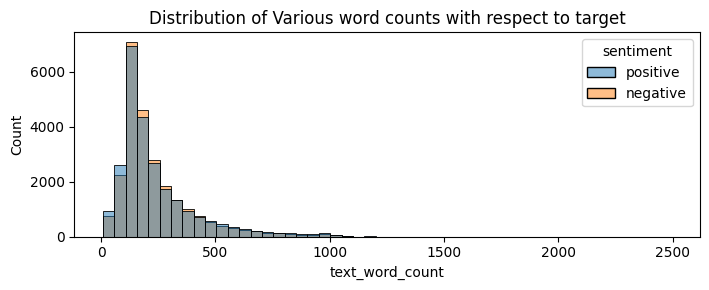

In [22]:
plt.figure(figsize=(20,3))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,hue='sentiment',bins=50)
    plt.title(f"Distribution of Various word counts with respect to target")
plt.tight_layout()
plt.show()

**The negative reviews are slightly longer on an average, compared to those with positive reviews.**

# Data Pre-prosessing

In [23]:
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
stop=set(stopwords.words('english'))
#Tokenization of text
tokenizer=ToktokTokenizer()

In [24]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Removing Emails
def remove_Emails(text):
    pattern=r'\S+@\S+'
    text=re.sub(pattern,'',text)
    return text

#Removing URLS
def remove_URLS(text):
    pattern=r'http\S+'
    text=re.sub(pattern,'',text)
    return text

#Removing special characters and white characters and punctuations
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing numbers
def remove_numbers(text):
    pattern = r'\d+'
    text = re.sub(pattern, '', text)
    return text

#LOWERCASE
def lowercase_text(text):
    return text.lower()

#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#removing the stopwords and conver to lower case
def remove_stopwords(text, is_lower_case=True):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Removing br word
def br_html(text):
    pattern=r'br'
    text = re.sub(pattern, '', text)
    return text

In [25]:
df['review']=df['review'].apply(denoise_text)
df['review']=df['review'].apply(remove_URLS)
df['review']=df['review'].apply(remove_Emails)
df['review']=df['review'].apply(remove_special_characters)
df['review']=df['review'].apply(remove_numbers)
df['review']=df['review'].apply(lowercase_text)

#let's see how data is looklike after these prosessing
random_index=random.randint(0,df.shape[0]-3)
for row in df[['review','sentiment']][random_index:random_index+3].itertuples():
    _,text,label=row
    class_name="Positive"
    if label==0:
        class_name="Negative"
    display(HTML(f"<h5><b style='color:red'>Text: </b>{text}</h5>"))
    display(HTML(f"<h5><b style='color:red'>Target: </b>{class_name}<br><hr></h5>"))

In [26]:
df['review']=df['review'].apply(br_html)

In [27]:
df['review'][0]

' this film was just illiant casting location scenery story direction everyones really suited the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just illiant so much that i bought the film as soon as it was released for  and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also  to the two little boys that played the  of norman and paul they were just illiant children are often left out of the  list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done dont you think the whole st

### Stemming & Lemmatization 

In the field of NLP, Lemmatization and Stemming are `Text Normalization techniques`. These techniques are used to prepare words, text, and documents for further processing.

**Stemming** is a process that stems or removes last few characters from a word.
- For instance, stemming the words` ‘History‘` & `‘Historical‘` would return `‘Histori‘`

Stemming often leading to incorrect meanings and spelling.
- For instance, stemming the word `‘Caring‘` would return `‘Car‘`


**Lemmatization** has the same purpose of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give may not give meaningful representation such as “Histori”. Here, lemmatization comes into picture as it gives meaningful word. In other words lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.
- For instance, lemmatizing the word `‘Caring‘` would return `‘Care‘`.



**Stemming vs.Lemmatization**

1- `Stemming` has its application in Sentiment Analysis while `Lemmatization` has its application in Chatbots, human-answering.

2- `Stemming` is used in case of large dataset where performance is an issue and speed is important , while `Lemmatization`is computationally expensive since it involves look-up tables and what not.


The package namely, `nltk.stem` is used to perform stemming via different classes. We import PorterStemmer from nltk.stem to perform the task.

In [28]:
'''print ('BEFORE (simple_stemmer).. \n',imdb['review'][2])
imdb['review']=imdb['review'].apply(simple_stemmer)
print ('AFTER (simple_stemmer) .. \n',imdb['review'][2])
# We wont use Steaming as output is nonesence '''

"print ('BEFORE (simple_stemmer).. \n',imdb['review'][2])\nimdb['review']=imdb['review'].apply(simple_stemmer)\nprint ('AFTER (simple_stemmer) .. \n',imdb['review'][2])\n# We wont use Steaming as output is nonesence "

In [29]:
def get_wordnet_pos(tag):
    """
    Map POS tag to first character used by WordNetLemmatizer
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun if POS tag is unknown

In [30]:
def preprocess_review(review):
    """
    Preprocess a single movie review by tokenizing and lemmatizing
    """
    lemmatizer = WordNetLemmatizer()
    # Tokenize the review into words
    words = nltk.word_tokenize(review)
    
    # Tag the words with their part-of-speech (POS) tags
    tagged_words = nltk.pos_tag(words)
    
    # Lemmatize the words using their POS tags
    lemmatized_words = []
    for word, tag in tagged_words:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    # Join the lemmatized words back into a single string
    preprocessed_review = ' '.join(lemmatized_words)
    
    return preprocessed_review

In [31]:
print ('BEFORE (remove_stopwords).. \n',df['review'][2])
df['review_lem']=df['review'].apply(preprocess_review)
print ('AFTER (remove_stopwords) .. \n',df['review_lem'][2])

BEFORE (remove_stopwords).. 
  this has to be one of the worst films of the s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had  working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i cant get across how  this is to watch save yourself an hour a bit of your life
AFTER (remove_stopwords) .. 
 this have to be one of the bad film of the s when my friend i be watch this film be the target audience it be aim at we just sit watch the first half an hour with our jaw touch the floor at how bad it really be the rest of the time everyone else in the theatre 

### Stop Words Removal 

The process of removing the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”.

**Why do we remove stop words? 🤷‍♀️**
- By removing these words, we remove the low-level information from our text in order to give more focus to the important information. 

- The Removal of stop words definitely reduces the dataset size and thus reduces the training time due to the fewer number of tokens involved in the training.

**P.S.**   We do not always remove the stop words. The removal of stop words is highly dependent on the task we are performing and the goal we want to achieve.

* Movie review: “The movie was not good at all.”

* Text after removal of stop words: “movie good”


In [32]:
print ('BEFORE (remove_stopwords).. \n',df['review_lem'][2])
df['review_lem']=df['review_lem'].apply(remove_stopwords)
print ('AFTER (remove_stopwords) .. \n',df['review_lem'][2])

BEFORE (remove_stopwords).. 
 this have to be one of the bad film of the s when my friend i be watch this film be the target audience it be aim at we just sit watch the first half an hour with our jaw touch the floor at how bad it really be the rest of the time everyone else in the theatre just start talk to each other leaving or generally cry into their popcorn that they actually pay money they have work to watch this feeble excuse for a film it must have look like a great idea on paper but on film it look like no one in the film have a clue what be go on crap act crap costume i cant get across how this be to watch save yourself an hour a bit of your life
AFTER (remove_stopwords) .. 
 one bad film friend watch film target audience aim sit watch first half hour jaw touch floor bad really rest time everyone else theatre start talk leaving generally cry popcorn actually pay money work watch feeble excuse film must look like great idea paper film look like one film clue go crap act crap c

# Save data so we don't do same operations each restart

In [34]:
df.to_csv('IMDB_Prosessed_V1.csv')

In [4]:
df=pd.read_csv('IMDB_Prosessed_V1.csv')

In [39]:
df.head()

,review,sentiment,text_word_count,review_lem
0,this film was just illiant casting location s...,positive,218,film illiant cast location scenery story direc...
1,big hair big boobs bad music and a giant safe...,negative,189,big hair big boob bad music giant safety pin w...
2,this has to be one of the worst films of the ...,negative,141,one bad film friend watch film target audience...
3,the at storytelling the traditional sort ma...,positive,550,storytelling traditional sort many year event ...
4,worst mistake of my life i picked this movi...,negative,147,bad mistake life pick movie target figure hey ...


### Tokenization 

`Tokenization` is a key (and mandatory) aspect of working with text data, Simply put, we can’t work with text data if we don’t perform tokenization.

`Tokenization` is a way of separating a piece of text into smaller units called tokens, they can be either (Words,Characters, Subwords (n-gram characters))

For example, let us consider `“smarter”`:

- Word : 'smarter'
- Character tokens: s-m-a-r-t-e-r
- Subword tokens: smart-er

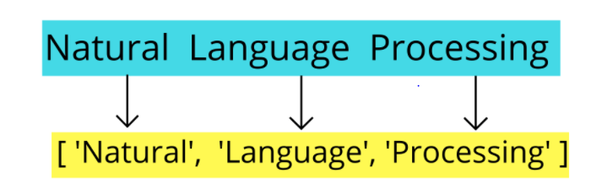

We will be performing following steps while solving this problem:

- Tokenize the sentences into words.
- Create one-hot encoded vector for each word.
- Use padding to ensure all sequences are of same length.
- Pass the padded sequences as input to embedding layer.
- Flatten and apply Dense layer to predict the label

In [5]:
#parameter for OOV tokens  is set to out of vocab and padding
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'
max_seq_length = 10000

In [6]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=10000,oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(df['review_lem'])


# Split data

In [7]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df['review_lem'], df['sentiment'].map({'positive': 1, 'negative': 0}), test_size=0.2, random_state=42)

In [8]:
# Generate and pad the training sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [9]:
x_train = pad_sequences(x_train, maxlen=max_seq_length, padding=padding_type, truncating=trunc_type)


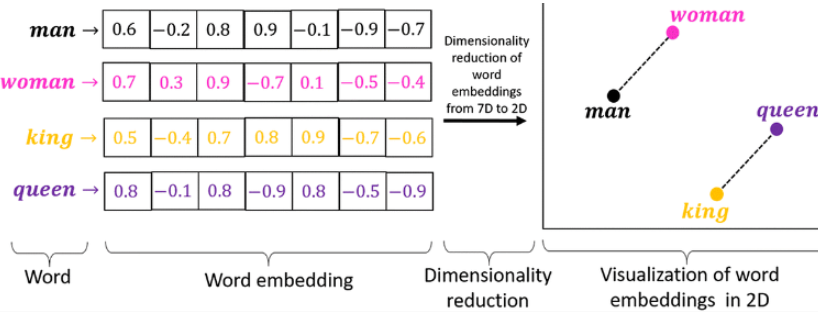

# Word2Vect

In [11]:
sentences = [review.split() for review in df['review_lem']]

In [12]:
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=8,sg=0)

In [12]:
model.save('imdb_word2vec.model')

# Test the model on some sample words

In [10]:
# Load the trained Word2Vec model
model = gensim.models.Word2Vec.load('imdb_word2vec.model')

# Test the model on some sample words
word1 = 'good'
word2 = 'bad'
word3 = 'movie'
word4 = 'action'


In [25]:
# Get the most similar words to word1 and word2
print("Most similar words to '{}' and '{}' are:".format(word1, word2))
print(model.wv.most_similar(positive=[word1], negative=[word2]))

# Check if word3 is present in the vocabulary
if word3 in model.wv.key_to_index:
    print("Word '{}' is present in the vocabulary".format(word3))
else:
    print("Word '{}' is not present in the vocabulary".format(word3))

# Check if word4 is present in the vocabulary
if word4 in model.wv.key_to_index:
    print("Word '{}' is present in the vocabulary".format(word4))
else:
    print("Word '{}' is not present in thevocabulary".format(word4))

Most similar words to 'good' and 'bad' are:
[('nice', 0.45118948817253113), ('solid', 0.4331172704696655), ('excellent', 0.42957931756973267), ('terrific', 0.40496009588241577), ('nicely', 0.4013063609600067), ('adventurous', 0.3981994092464447), ('wonderful', 0.3973139524459839), ('great', 0.38188308477401733), ('provide', 0.37084630131721497), ('lends', 0.3702375292778015)]
Word 'movie' is present in the vocabulary
Word 'action' is present in the vocabulary


* As you can see, the model returns a list of the most similar words to 'good' and 'bad', and checks if 'movie' and 'action' are present in the vocabulary.

# Now you Ready to build your model From build any model i will build a simple model using embeddings from Word2vec

In [11]:
vocab_size = len(model.wv.key_to_index)
embedding_dim = 100

In [12]:
# Generate word embeddings from the model
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(model.wv.index_to_key):
    embedding_matrix[i] = model.wv[word]

In [21]:
# Build the model
with tf.device('/GPU:0'):
    model_lstm = Sequential ([
            Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[embedding_matrix],trainable=False),
            Bidirectional(LSTM(100, return_sequences=True, dropout=0.35, recurrent_dropout=0.35)),
            Conv1D(100, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(100, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

# Set the training parameters
    optimizer = Adam(learning_rate=0.001)
    model_lstm.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    # Print the model summary
# model_lstm.summary()
    

In [14]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         860900    
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        160800    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, None, 100)         100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0

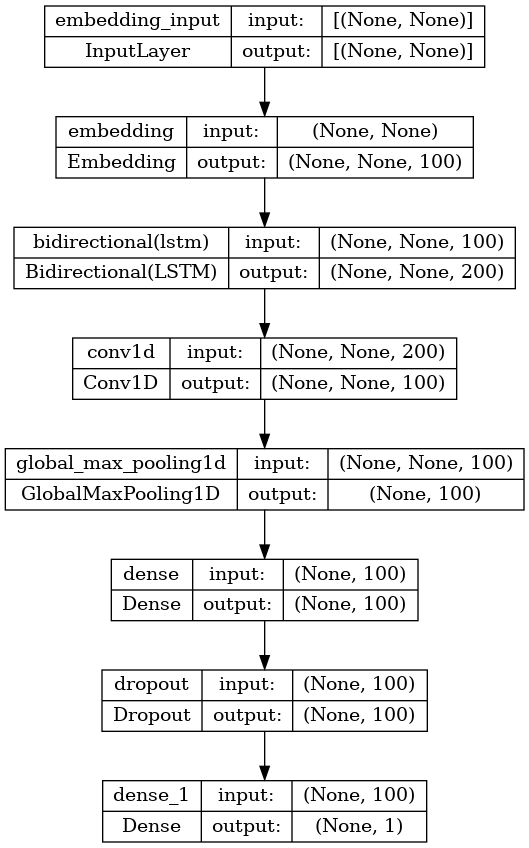

In [17]:
tf.keras.utils.plot_model(model_lstm,show_shapes=True)

In [2]:
from tensorflow.keras.callbacks import TensorBoard

# create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

In [ ]:
# Train the model
from sklearn.metrics import f1_score
with tf.device('/GPU:0'):
    early_stopping = EarlyStopping(patience=3)
    history_lstm = model_lstm.fit(x_train,y_train, epochs=5,batch_size=128,verbose = 1,validation_split=0.25,callbacks=[early_stopping, tensorboard_callback])

Epoch 1/5


In [ ]:
 _, accuracy = model_lstm.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy}")

In [ ]:
y_pred = model_lstm.predict(x_test)
# Convert the predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)
# Compute the F1 score
f1 = f1_score(validation_labels, y_pred)
# Print the F1 score
print("F1 score:", f1)

In [ ]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''

    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,5))

    # plot loss data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
    # plt.show()

    
    # plot accuracy data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);



    plt.title('Model Performance Curves')


plot_loss_curves(history_lstm)